# Autoencoder Convolucional SPM1 - Pt. 3

Para finalizar el estudio de SPM a primer orden, entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ - en los tres canales - HH, HV y VV - al mismo tiempo.

## Cargamos los modelos y generamos los datos



In [1]:
# Monto los archivos al drive y cargo las funciones que voy a usar
#from google.colab import drive
#drive.mount('/content/drive/')

# integral gaussiana
# !cp "/content/drive/My Drive/Colab Notebooks/proyecto_pict/int_gauss.py" .
#!cp "/content/drive/My Drive/spm_layers/int_gauss.py" .

# # SPM Orden UNO
#!cp "/content/drive/My Drive/spm_layers/spm1.py" .

# Importo el modelo desarrollado por Marian: ecuación (27) del paper de Moghaddam.
from spm1 import S01HH
from spm1 import S01VV
from spm1 import S01HV
from spm1 import kix
from spm1 import kiy

In [2]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

# Parámetros fijos
acf = 1
realizations = 30000

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.25
d = np.linspace(.5, 1.5, 50)
ep1, ep2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = np.linspace(.005, .025, 50), np.linspace(.005, .025, 50)
l1, l2 = np.linspace(.05, .25, 50), np.linspace(.05, .25, 50)
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi/180, np.linspace(0, 360, 30)*np.pi/180 
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1], 3))


for i in range(realizations):
  # Genero una tira de indices aleatorios
  index = rng.integers(50, size=10)
  
  # Calculo el vector de onda incidente parallelo 
  kx_i = kix(k0, theta_i, phi_i)
  ky_i = kiy(k0, theta_i, phi_i)
  k1 = kx - kx_i
  k2 = ky - ky_i

  # Armo una tupla con los argumentos de S01     
  args = (k0, theta_i, phi_i,
           THETA, PHI, 
           ep1[index[0]], ep2[index[1]],
           d[index[2]], s1[index[3]], l1[index[4]],
           s2[index[5]], l2[index[6]],
           k1, k2, acf)
  
  # Calculo la sección eficaz y agrego ruido
  # v-pol
  s_vv = S01VV(*args)
  s_vv_noise = s_vv + rng.normal(0, .03*np.mean(s_vv), size = PHI.shape)

  # h-pol
  s_hh = S01HH(*args)
  s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size = PHI.shape)

  s_hv = S01HV(*args)
  s_hv_noise = s_hv + rng.normal(0, .03*np.mean(s_hv), size = PHI.shape)

  # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
  cond = np.count_nonzero(np.isnan(s_hh_noise))              # Cuenta cantidad de NaNs
  if cond == 0: 
    stack = np.dstack((s_hh_noise/np.max(np.abs(s_hh_noise)),
                      s_hv_noise/np.max(np.abs(s_hv_noise)), 
                     s_vv_noise/np.max(np.abs(s_vv_noise))))
    sigma[i,:,:,:] = stack
  

/home/tele/proyects/tesis/src/small_perturbation_method/spm1.py:97: RuntimeWarning: divide by zero encountered in true_divide
  return (2*kiz(k0,thi))/(-k1zi(k0,thi,ep1) + kiz(k0,thi) + ((k1zi(k0,thi,ep1) + k2zi(k0,thi,ep2))*(k1zi(k0,thi,ep1) + kiz(k0,thi)))/(exp(2*1j*d*k1zi(k0,thi,ep1))*(k1zi(k0,thi,ep1) - k2zi(k0,thi,ep2))))
/home/tele/proyects/tesis/src/small_perturbation_method/spm1.py:97: RuntimeWarning: invalid value encountered in true_divide
  return (2*kiz(k0,thi))/(-k1zi(k0,thi,ep1) + kiz(k0,thi) + ((k1zi(k0,thi,ep1) + k2zi(k0,thi,ep2))*(k1zi(k0,thi,ep1) + kiz(k0,thi)))/(exp(2*1j*d*k1zi(k0,thi,ep1))*(k1zi(k0,thi,ep1) - k2zi(k0,thi,ep2))))


In [3]:
# Chequeo el tamaño de los datos
shape = sigma.shape
print('Tamaños de los datos originales:', shape)

Tamaños de los datos originales: (30000, 30, 30, 3)


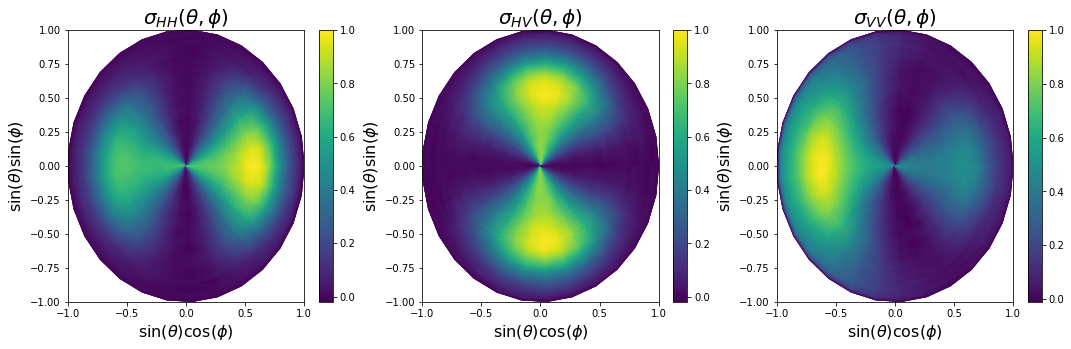

In [4]:
index = rng.integers(shape[0]) 
img = sigma[index,:,:,:]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal HV
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,1],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(1, 3, 3)
c = ax.pcolormesh(kx, ky, sigma[index,:,:,2],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()


Visualizo alguno de los datos

## Preparo los datos y defino el Autoencoder

In [5]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.2)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (24000, 30, 30, 3)
Tamaño de los datos de testeo: (6000, 30, 30, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class Autoencoder_conv(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,3)), 
                                            layers.Conv2D(16, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(4, (4, 4), strides=2, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Flatten(),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            
                                            layers.Reshape(target_shape=(10,10,4)),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(4, (4, 4), strides=2, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(16, (5, 5), strides=1, activation = 'relu'),
                                            layers.Conv2D(3, (4, 4), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  

2021-11-02 12:53:56.809913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 12:53:56.809964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
autoencoder = Autoencoder_conv(8)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()
plt.show()

2021-11-02 15:36:57.987531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-02 15:36:57.987565: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 15:36:57.987583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lionelhutz): /proc/driver/nvidia/version does not exist
2021-11-02 15:36:57.987755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 15:36:58.505078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Opt

# Visualizamos los resultados 

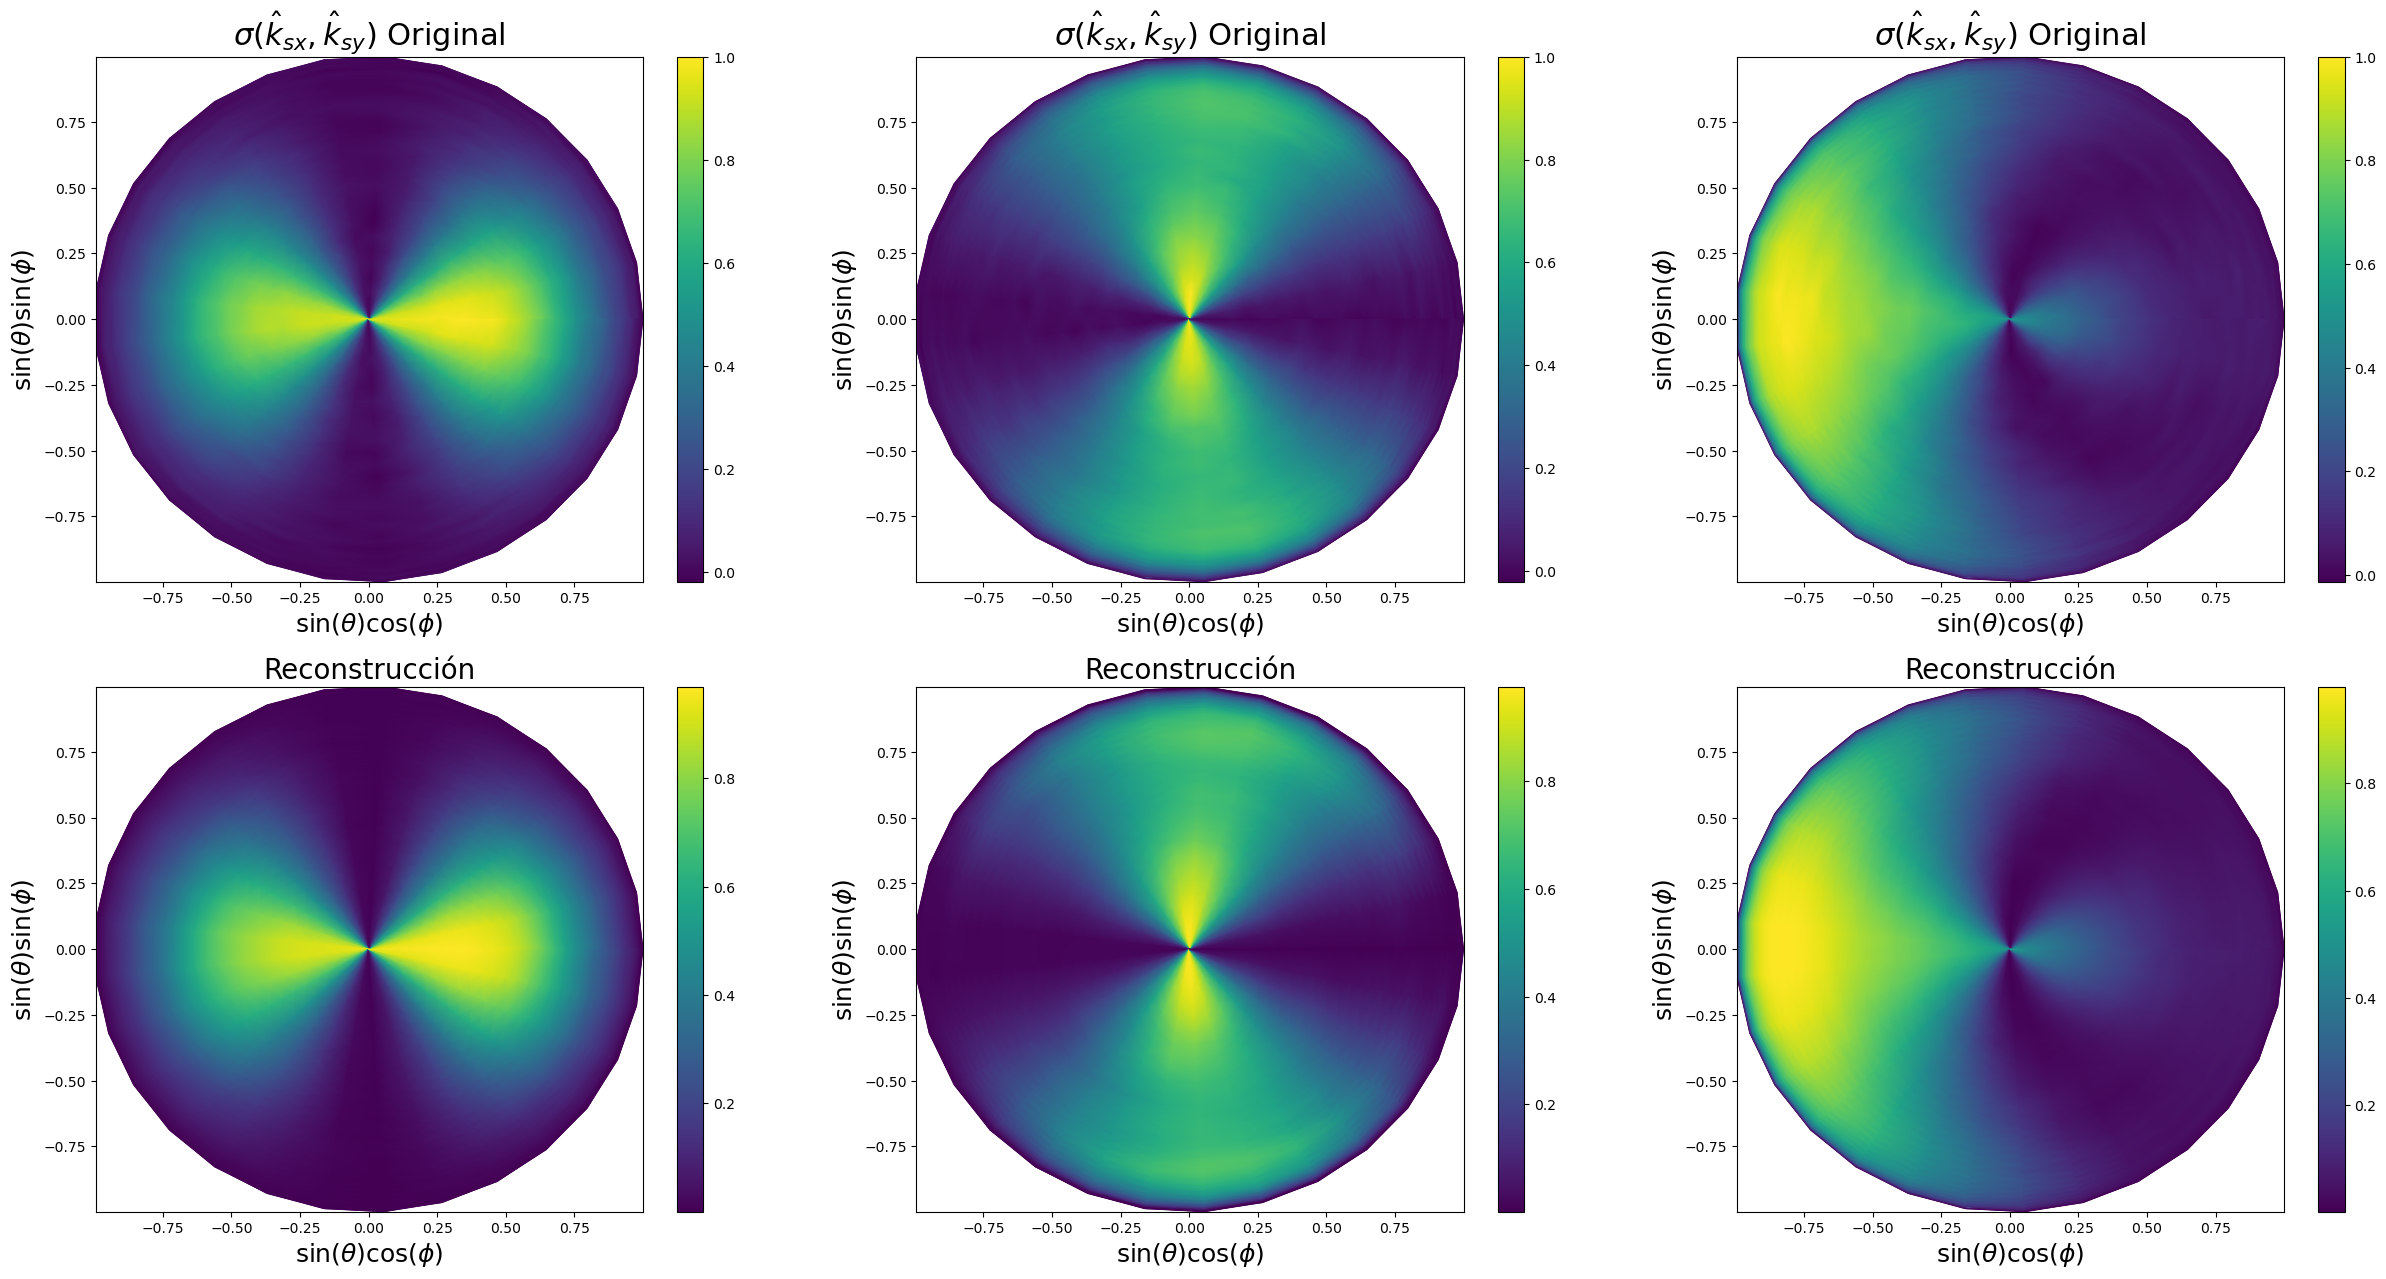

In [ ]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(sigma_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 3
# Reflectividad
fig=plt.figure(figsize=(30, 15)) 
for i in range(n):
    index = rng.integers(sigma_test.shape[0])

    # Imagen original
    s = sigma_test[index, :, :, i]
    #s.resize((sigma_test.shape[1], sigma_test.shape[2]))
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(r"$\sigma(\hat{k}_{sx},\hat{k}_{sy})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, i]
    #s_recons.resize((sigma_test.shape[1], sigma_test.shape[2]))
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title("Reconstrucción", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


In [ ]:
# Guardamos los pesos de la red entrenada
import os
file_name= 'results/weights_lat_8_spm1.h5'
folder = os.getcwd().split('/')[:-1]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

## Variamos la dimensión del Espacio Latente

In [ ]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = Autoencoder_conv(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))


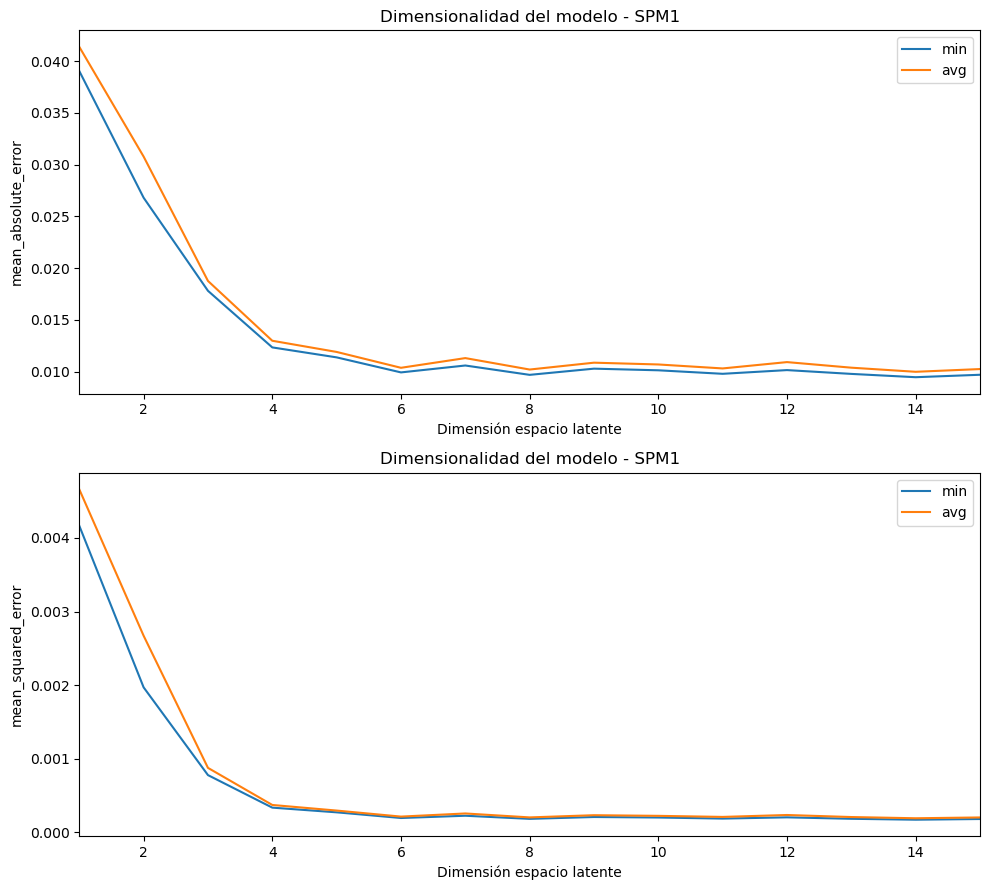

NameError: name 'folder' is not defined

In [3]:
img_name= 'results/cost_SPM_two_layer_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo - SPM1')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo - SPM1')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 


In [ ]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SPM_two_layer_ngi.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)
